# Project title: Binary Classification


#### In this project we will be using the given videos stored in a tensor format that holds 18 different categories of objects inside these videos and also extra information such as the bounding boxes of the objects, coordinates, segmentation masks, depth masks,..etc.

* first we will load the data using the method provided by the professor in the given notebook("project.ipynb").

* then we will divide the videos into frames to facilitate dealing with the data.

* then we will extract the categories of the objects for each frame which will be our labels for the classification task.
* we will explore the data and visualize a sample of it to help us decide which class we will use to apply our Binary Classification task.


* after selecting the class we will use,  we will modify the labels to be 1 for the selected class and 0 for the rest of the classes.


* finally we will apply some preprocessing techniques to prepare the data for the classification task.



## import library

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator

c:\Users\Shenhapy\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## load data

In [3]:
# in this section we will load the data from the tensorflow dataset
tfds.disable_progress_bar()
PROJECT_ROOT_DIR ="E:\OneDrive - University of Ottawa\CV\CV Project"
print(PROJECT_ROOT_DIR)

data_path = os.path.join(PROJECT_ROOT_DIR, 'tensorflow_data')
data_path = os.path.join(data_path, 'tensorflow_data')
os.makedirs(data_path, exist_ok = True)
print("Using directory: ", data_path)

flow_data_set_linear   = tfds.load('elg7186_projectdata/linear_movement_rotate', data_dir=data_path)
flow_data_set_rotation = tfds.load('elg7186_projectdata/rotation_rotate', data_dir=data_path)
flow_data_set_fixed    = tfds.load('elg7186_projectdata/fixed_random_rotate', data_dir=data_path)


E:\OneDrive - University of Ottawa\CV\CV Project
Using directory:  E:\OneDrive - University of Ottawa\CV\CV Project\tensorflow_data\tensorflow_data


In [4]:
# this function is used to make a dataframe from the tensorflow dataset by iterating through the videos then take the frames
# for each video and append them to the dataframe with the corresponding categories

def make_df(data_set):
    df_list = []  # Create a list to hold DataFrames
    iter_data = iter(data_set['train'])
    
    for i in range(len(data_set['train'])):
        train_data = next(iter_data)
        video_frames = []
        
        for j in range(len(train_data['video'])):
            video_frames.append({'img': np.array(train_data['video'][j, :, :, :]),
                                 'y': train_data['instances']['category'].numpy()})
        
        df_list.append(pd.DataFrame(video_frames))
    
    return pd.concat(df_list, ignore_index=True)

# Create dataframes for each dataset
df_linear = make_df(flow_data_set_linear)  # 720 frames
df_fixed = make_df(flow_data_set_fixed)    # 720 frames
df_rot = make_df(flow_data_set_rotation)   # 720 frames

# Concatenate the dataframes into one dataframe
df = pd.concat([df_linear, df_fixed, df_rot], ignore_index=True)  # 2160 frames


In [5]:
df.sample(5)

,img,y
1173,"[[[162, 204, 216], [161, 204, 216], [163, 205,...","[16, 14, 13]"
966,"[[[171, 168, 173], [170, 170, 177], [167, 161,...","[14, 14, 9]"
442,"[[[54, 54, 43], [77, 79, 62], [62, 57, 45], [7...","[13, 14, 14]"
34,"[[[201, 88, 52], [200, 85, 49], [201, 82, 46],...","[6, 16, 13]"
1256,"[[[130, 123, 109], [127, 120, 106], [116, 110,...","[14, 6, 13, 6, 16, 6, 14]"


In [6]:
# datasets shapes
print(df_linear.shape)
print(df_fixed.shape)
print(df_rot.shape)

(720, 2)
(720, 2)
(720, 2)


## visualizing some examples

In [7]:
df_rot.sample(5)

,img,y
480,"[[[137, 150, 168], [138, 151, 168], [136, 148,...","[6, 14, 3, 16, 6, 14]"
603,"[[[135, 132, 111], [133, 131, 114], [88, 92, 7...","[13, 0, 14]"
106,"[[[124, 109, 94], [129, 115, 100], [144, 132, ...","[16, 14, 13]"
469,"[[[231, 184, 159], [236, 190, 163], [237, 190,...","[14, 13, 14]"
186,"[[[56, 49, 38], [55, 48, 37], [54, 46, 36], [5...",[1]


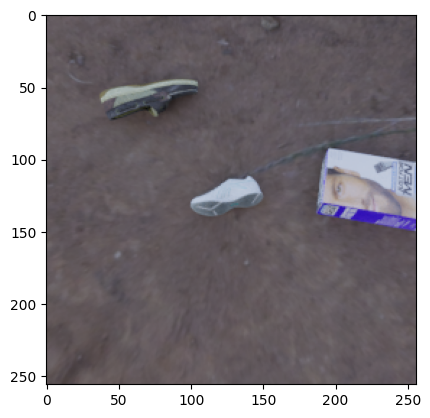

In [8]:
plt.imshow(np.array(df_rot['img'][426]))

## sample of data

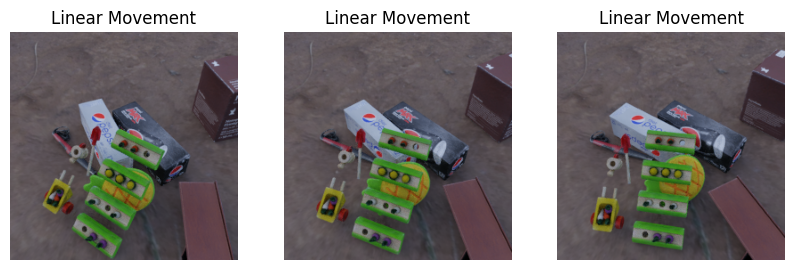

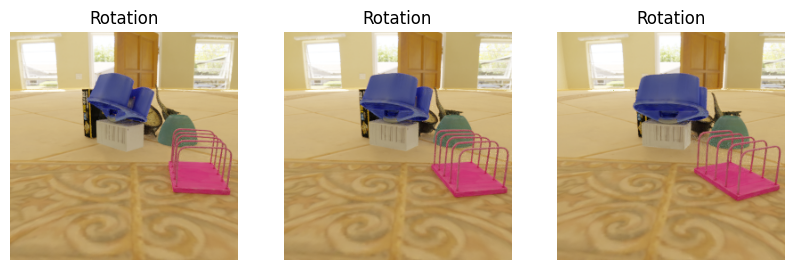

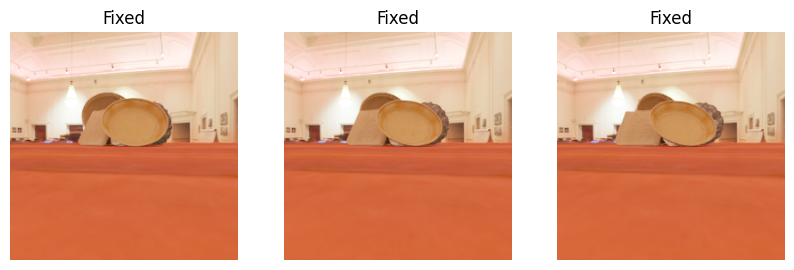

In [9]:
# in this section we will visualize the data by plotting some images from each dataset to see the difference between them

#linear move dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_linear['img'][0])
ax[0].set_title('Linear Movement')
ax[0].axis('off')
ax[1].imshow(df_linear['img'][1])
ax[1].set_title('Linear Movement')
ax[1].axis('off')
ax[2].imshow(df_linear['img'][2])
ax[2].set_title('Linear Movement')
ax[2].axis('off')
plt.show()

# rotation dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_rot['img'][0])
ax[0].set_title('Rotation')
ax[0].axis('off')
ax[1].imshow(df_rot['img'][1])
ax[1].set_title('Rotation')
ax[1].axis('off')
ax[2].imshow(df_rot['img'][2])
ax[2].set_title('Rotation')
ax[2].axis('off')
plt.show()


#fixed dataset
fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(df_fixed['img'][0])
ax[0].set_title('Fixed')
ax[0].axis('off')
ax[1].imshow(df_fixed['img'][1])
ax[1].set_title('Fixed')
ax[1].axis('off')
ax[2].imshow(df_fixed['img'][2])
ax[2].set_title('Fixed')
ax[2].axis('off')
plt.show()

In [10]:
# getting the most frequent class to classify based on it to gurantee data balance
from collections import Counter
Counter([item for sublist in df['y'] for item in sublist]).most_common(1)

[(14, 2208)]

## make a copy from the dataframe to keep the original one away from modification

In [11]:
import copy
df_copy = copy.deepcopy(df)
df_copy['z'] = df_copy['y'].apply(lambda x: 1 if 14 in x else 0)  # 14 is shoe

In [12]:
df_copy.sample(5)

,img,y,z
1397,"[[[84, 81, 83], [85, 82, 84], [87, 84, 85], [9...","[6, 13, 14]",1
1886,"[[[105, 138, 176], [103, 135, 173], [105, 136,...",[0],0
225,"[[[195, 178, 140], [194, 177, 143], [198, 183,...","[6, 14, 14]",1
1207,"[[[17, 65, 138], [20, 65, 134], [50, 73, 123],...",[6],0
1462,"[[[198, 179, 124], [197, 178, 122], [197, 178,...","[13, 6, 6, 13, 13, 0, 6]",0


## Now we should check for the data balance to avoid any problems that may appear due to data imbalance

Text(0.5, 1.0, 'Histogram of Shoe(1) vs. Non-Shoe(0)')

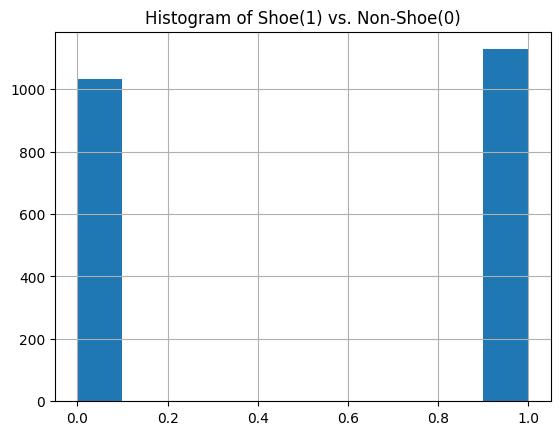

In [13]:
df_copy['z'].hist()
title = 'Histogram of Shoe(1) vs. Non-Shoe(0)'
plt.title(title)

## As we see the chosen class "shoe" (14) is a great choice for our binary classification problem

## Image preprocessing

In [20]:
# This function is used to preprocess the images by resizing them to 128x128,
# then enhancing them using unsharp mask, then denoising them

def preprocess_image(img, desired_size=(128, 128)):
    # Resizing
    img = resize(img, desired_size)

    # Enhancing the image using unsharp mask
    # img = unsharp_mask(img)

    # Denoising
    # sigma_est = np.mean(estimate_sigma(img))
    # img = denoise_nl_means(img, h=1.15 * sigma_est, fast_mode=True)

    # Histogram Equalization for enhancing contrast
    # img = equalize_hist(img)

    # Convert to grayscale
    # gray_img = rgb2gray(img)

    # Expand the dimensions to fit the model input shape
    return np.expand_dims(img, axis=-1)

C:\Users\Shenhapy\AppData\Local\Temp\ipykernel_24064\82202150.py:12: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  sigma_est = np.mean(estimate_sigma(img))
c:\Users\Shenhapy\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\_shared\utils.py:316: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


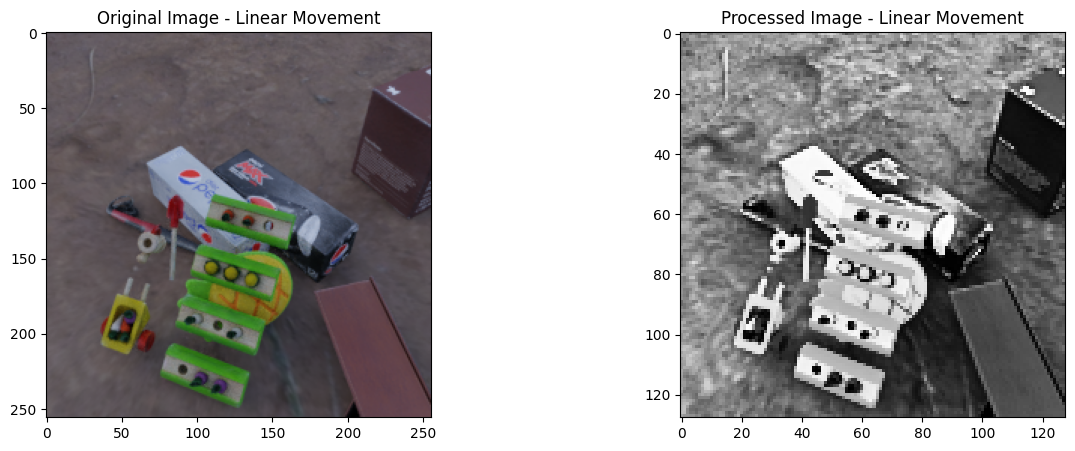

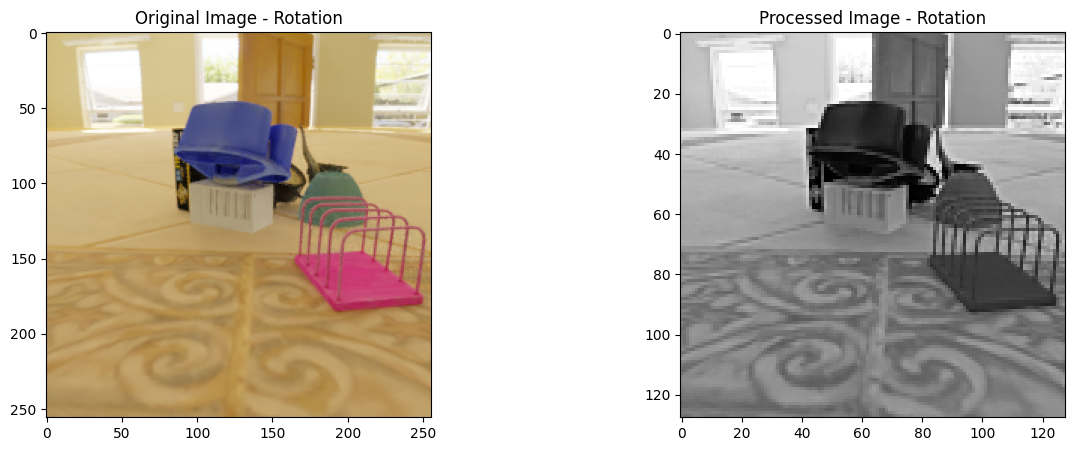

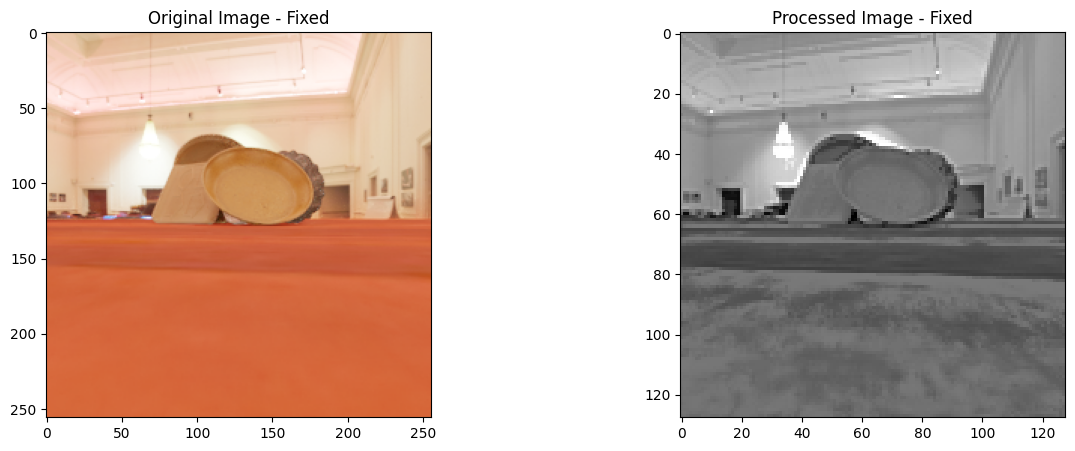

In [15]:
# this function is used to display the images before and after preprocessing
def display_image_processing(df, title):
      img = df['img'][1]
      processed_img = preprocess_image(img)
      fig, ax = plt.subplots(1, 2, figsize=(15, 5))
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image - {title}")
      ax[1].imshow(processed_img.squeeze(), cmap='gray')
      ax[1].set_title(f"Processed Image - {title}")
      plt.show()

# Display for each dataframe
display_image_processing(df_linear, 'Linear Movement')
display_image_processing(df_rot, 'Rotation')
display_image_processing(df_fixed, 'Fixed')

# Now the data is ready for the training step

# Resnet

In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [21]:
df_copy_preprocess = copy.deepcopy(df_copy)

# Apply preprocessing to all images
df_copy_preprocess['img'] = df_copy_preprocess['img'].apply(preprocess_image)

In [22]:
train_data, temp_data = train_test_split(df_copy_preprocess, test_size=0.3, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

# Convert the list of processed images into an array
X_train = np.array(train_data['img'].tolist())
X_test = np.array(test_data['img'].tolist())
X_val = np.array(val_data['img'].tolist())

# Labels
y_train = train_data['z'].values
y_test = test_data['z'].values
y_val = val_data['z'].values

In [23]:
# Define the base model using ResNet50
input_tensor = Input(shape=(128, 128, 3))
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_data=(X_val, y_val),
    epochs=10
)

Epoch 1/10
48/48 [==============================] - 38s 716ms/step - loss: 1.1009 - accuracy: 0.5311 - val_loss: 0.6574 - val_accuracy: 0.4877
Epoch 2/10
48/48 [==============================] - 36s 742ms/step - loss: 0.6358 - accuracy: 0.6369 - val_loss: 0.5938 - val_accuracy: 0.6944
Epoch 3/10
48/48 [==============================] - 34s 705ms/step - loss: 0.5978 - accuracy: 0.6759 - val_loss: 0.5645 - val_accuracy: 0.7315
Epoch 4/10
48/48 [==============================] - 33s 692ms/step - loss: 0.5764 - accuracy: 0.6964 - val_loss: 0.5567 - val_accuracy: 0.7068
Epoch 5/10
48/48 [==============================] - 33s 695ms/step - loss: 0.5862 - accuracy: 0.6845 - val_loss: 0.5314 - val_accuracy: 0.7315
Epoch 6/10
48/48 [==============================] - 34s 711ms/step - loss: 0.5646 - accuracy: 0.6984 - val_loss: 0.5210 - val_accuracy: 0.7593
Epoch 7/10
48/48 [==============================] - 32s 665ms/step - loss: 0.5170 - accuracy: 0.7480 - val_loss: 0.5163 - val_accuracy: 0.7377

11/11 [==============================] - 5s 412ms/step


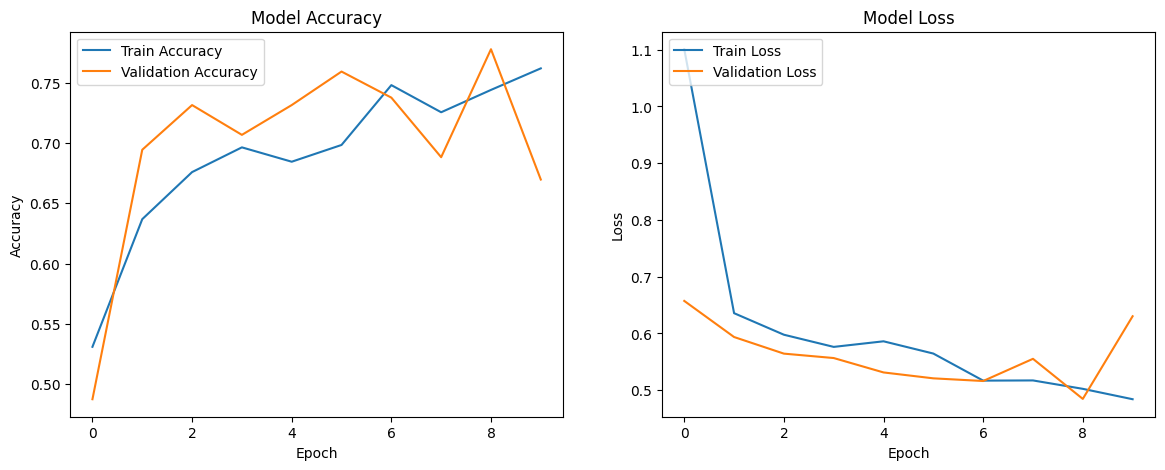

In [24]:
# Predictions for training and testing sets
y_pred_train = model.predict(X_train)
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

Classification Report for Training Set:
              precision    recall  f1-score   support

    Non-Shoe       0.58      0.98      0.73       709
        Shoe       0.96      0.38      0.55       803

    accuracy                           0.66      1512
   macro avg       0.77      0.68      0.64      1512
weighted avg       0.79      0.66      0.63      1512



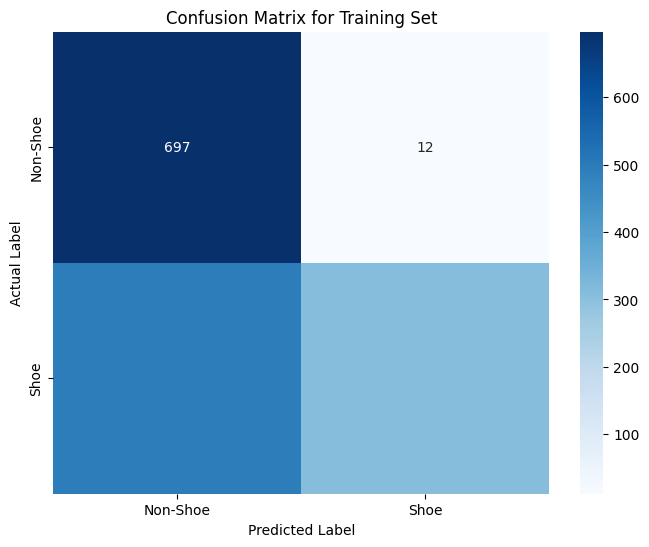

Classification Report for Testing Set:
              precision    recall  f1-score   support

    Non-Shoe       0.57      0.99      0.72       157
        Shoe       0.98      0.29      0.45       167

    accuracy                           0.63       324
   macro avg       0.77      0.64      0.59       324
weighted avg       0.78      0.63      0.58       324



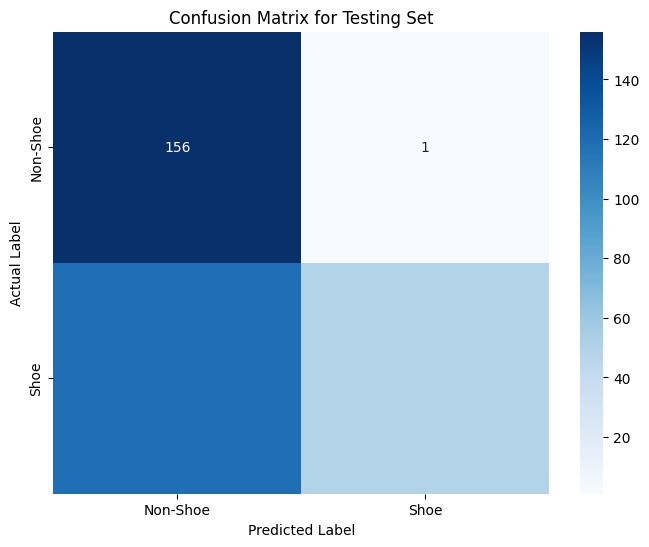

In [25]:
# Function to plot confusion matrix and print classification report
def evaluate_performance(y_true, y_pred, dataset_type='Training'):
    print(f'Classification Report for {dataset_type} Set:')
    print(classification_report(y_true, y_pred, target_names=['Non-Shoe', 'Shoe']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Shoe', 'Shoe'], yticklabels=['Non-Shoe', 'Shoe'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {dataset_type} Set')
    plt.show()

# Evaluate performance on training set
evaluate_performance(y_train, y_pred_train, 'Training')

# Evaluate performance on testing set
evaluate_performance(y_test, y_pred_test, 'Testing')

# Inception

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
# Define the model using InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout added
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

87910968/87910968 [==============================] - 7s 0us/step


Epoch 1/10
48/48 [==============================] - 76s 1s/step - loss: 0.3827 - accuracy: 0.8591 - val_loss: 8.1285 - val_accuracy: 0.4877
Epoch 2/10
48/48 [==============================] - 57s 1s/step - loss: 0.1415 - accuracy: 0.9491 - val_loss: 4.0781 - val_accuracy: 0.6049
Epoch 3/10
48/48 [==============================] - 56s 1s/step - loss: 0.1011 - accuracy: 0.9696 - val_loss: 271.0034 - val_accuracy: 0.6358
Epoch 4/10
48/48 [==============================] - 59s 1s/step - loss: 0.2146 - accuracy: 0.9530 - val_loss: 1.1661 - val_accuracy: 0.6389
Epoch 5/10
48/48 [==============================] - 56s 1s/step - loss: 0.3902 - accuracy: 0.8763 - val_loss: 7.0009 - val_accuracy: 0.4630
Epoch 6/10
48/48 [==============================] - 54s 1s/step - loss: 0.0580 - accuracy: 0.9835 - val_loss: 1.0074 - val_accuracy: 0.8086
Epoch 7/10
48/48 [==============================] - 53s 1s/step - loss: 0.0324 - accuracy: 0.9921 - val_loss: 0.0286 - val_accuracy: 0.9938
Epoch 8/10
48/48 [

In [28]:
# Predictions for training and testing sets
y_pred_train = model.predict(X_train)
y_pred_train = (y_pred_train > 0.5).astype(int)
y_pred_test = model.predict(X_test)
y_pred_test = (y_pred_test > 0.5).astype(int)

11/11 [==============================] - 2s 161ms/step


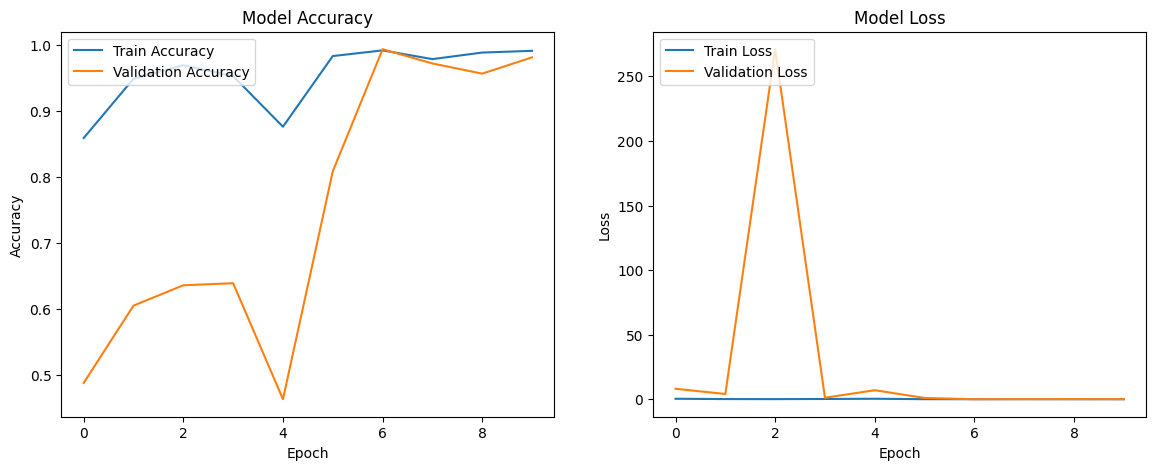

In [29]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()

Classification Report for Training Set:
              precision    recall  f1-score   support

    Non-Shoe       0.98      0.98      0.98       709
        Shoe       0.99      0.98      0.98       803

    accuracy                           0.98      1512
   macro avg       0.98      0.98      0.98      1512
weighted avg       0.98      0.98      0.98      1512



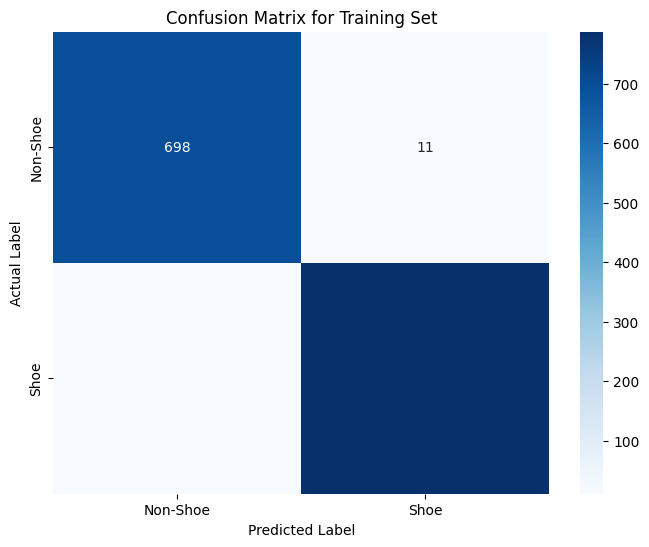

Classification Report for Testing Set:
              precision    recall  f1-score   support

    Non-Shoe       0.97      0.96      0.96       157
        Shoe       0.96      0.97      0.97       167

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



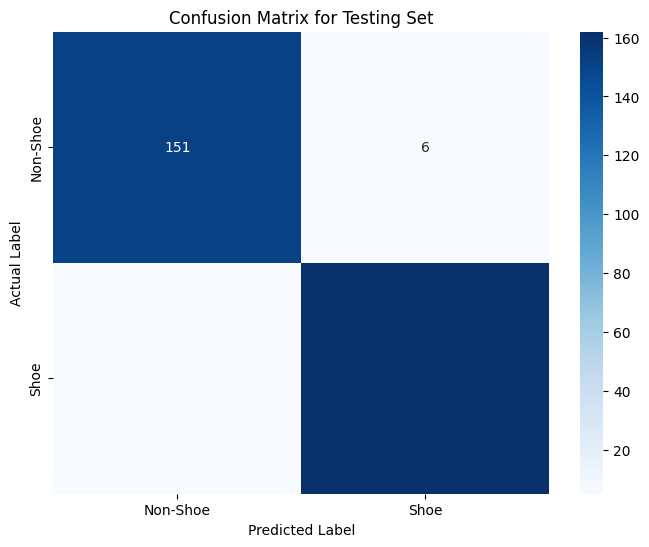

In [30]:
import seaborn as sns
# Function to plot confusion matrix and print classification report
def evaluate_performance(y_true, y_pred, dataset_type='Training'):
    print(f'Classification Report for {dataset_type} Set:')
    print(classification_report(y_true, y_pred, target_names=['Non-Shoe', 'Shoe']))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Shoe', 'Shoe'], yticklabels=['Non-Shoe', 'Shoe'])
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix for {dataset_type} Set')
    plt.show()

# Evaluate performance on training set
evaluate_performance(y_train, y_pred_train, 'Training')

# Evaluate performance on testing set
evaluate_performance(y_test, y_pred_test, 'Testing')

# InceptionResNetV2

The InceptionResNetV2_Model function is intended for image classification tasks using the InceptionResNetV2 architecture. It takes in training, validation, and test data along with a pre-initialized InceptionResNetV2 model. The function then configures the model with an Adam optimizer using a binary cross-entropy loss function and accuracy as the metric. It fits the model to the provided training data for a specified number of epochs, utilizing the validation data for validation during training.

The function computes various evaluation metrics such as loss, accuracy, and confusion matrix for the training, validation, and test sets. Finally, it returns these evaluation metrics along with the trained model for further analysis.

In [31]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from collections import Counter
from skimage.filters import unsharp_mask
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_hist
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2

In [32]:
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    # Evaluate the model on the training set
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    train_pred = (model.predict(X_train) > 0.5).astype(int)
    train_cm = confusion_matrix(y_train, train_pred)

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    val_pred = (model.predict(X_val) > 0.5).astype(int)
    val_cm = confusion_matrix(y_val, val_pred)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_pred = (model.predict(X_test) > 0.5).astype(int)
    test_cm = confusion_matrix(y_test, test_pred)

    # Plotting Confusion Matrices
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    sns.heatmap(train_cm, annot=True, cmap='Pastel2', ax=axs[0], fmt='g')
    axs[0].set_title('Training Confusion Matrix')
    axs[0].set_xlabel('Predicted Labels')
    axs[0].set_ylabel('Actual Labels')

    sns.heatmap(val_cm, annot=True, cmap='Pastel1', ax=axs[1], fmt='g')
    axs[1].set_title('Validation Confusion Matrix')
    axs[1].set_xlabel('Predicted Labels')
    axs[1].set_ylabel('Actual Labels')

    sns.heatmap(test_cm, annot=True, cmap='Pastel2', ax=axs[2], fmt='g')
    axs[2].set_title('Testing Confusion Matrix')
    axs[2].set_xlabel('Predicted Labels')
    axs[2].set_ylabel('Actual Labels')

    plt.tight_layout()
    plt.show()

In [33]:
def evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    def calculate_metrics(X, y):
        y_pred = model.predict(X)
        y_pred_classes = (y_pred > 0.5).astype(int)
        accuracy = accuracy_score(y, y_pred_classes)
        f1 = f1_score(y, y_pred_classes)

        loss = model.evaluate(X, y, verbose=0)[0]

        return accuracy, f1, loss

    train_accuracy, train_f1, train_loss = calculate_metrics(X_train, y_train)
    val_accuracy, val_f1, val_loss = calculate_metrics(X_val, y_val)
    test_accuracy, test_f1, test_loss = calculate_metrics(X_test, y_test)

    results = {
        'Training': {
            'Accuracy': train_accuracy,
            'F1 Score': train_f1,
            'Loss': train_loss
        },
        'Validation': {
            'Accuracy': val_accuracy,
            'F1 Score': val_f1,
            'Loss': val_loss
        },
        'Test': {
            'Accuracy': test_accuracy,
            'F1 Score': test_f1,
            'Loss': test_loss
        }
    }

    return results

In [34]:
def plot_learning_curves(history):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [60]:
def build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the Inception-ResNetV2 model
    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Evaluate the model on training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    # Evaluate the model on validation data
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    y_val_pred = model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    y_test_pred = model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history


In [61]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history = build_and_train_inception_resnet(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
48/48 [==============================] - 51s 851ms/step - loss: 0.9194 - accuracy: 0.6210 - val_loss: 0.5157 - val_accuracy: 0.7593
Epoch 2/10
48/48 [==============================] - 36s 763ms/step - loss: 0.5199 - accuracy: 0.7705 - val_loss: 0.3359 - val_accuracy: 0.8704
Epoch 3/10
48/48 [==============================] - 36s 761ms/step - loss: 0.3448 - accuracy: 0.8479 - val_loss: 0.2843 - val_accuracy: 0.8951
Epoch 4/10
48/48 [==============================] - 37s 766ms/step - loss: 0.2975 - accuracy: 0.8816 - val_loss: 0.2555 - val_accuracy: 0.8920
Epoch 5/10
48/48 [==============================] - 37s 764ms/step - loss: 0.2547 - accuracy: 0.9028 - val_loss: 0.2146 - val_accuracy: 0.9259
Epoch 6/10
48/48 [==============================] - 37s 764ms/step - loss: 0.2015 - accuracy: 0.9272 - val_loss: 0.2074 - val_accuracy: 0.9321
Epoch 7/10
48/48 [==============================] - 37s 768ms/step - loss: 0.1723 - accuracy: 0.9438 - val_loss: 0.1752 - val_accuracy: 0.9475

11/11 [==============================] - 6s 581ms/step


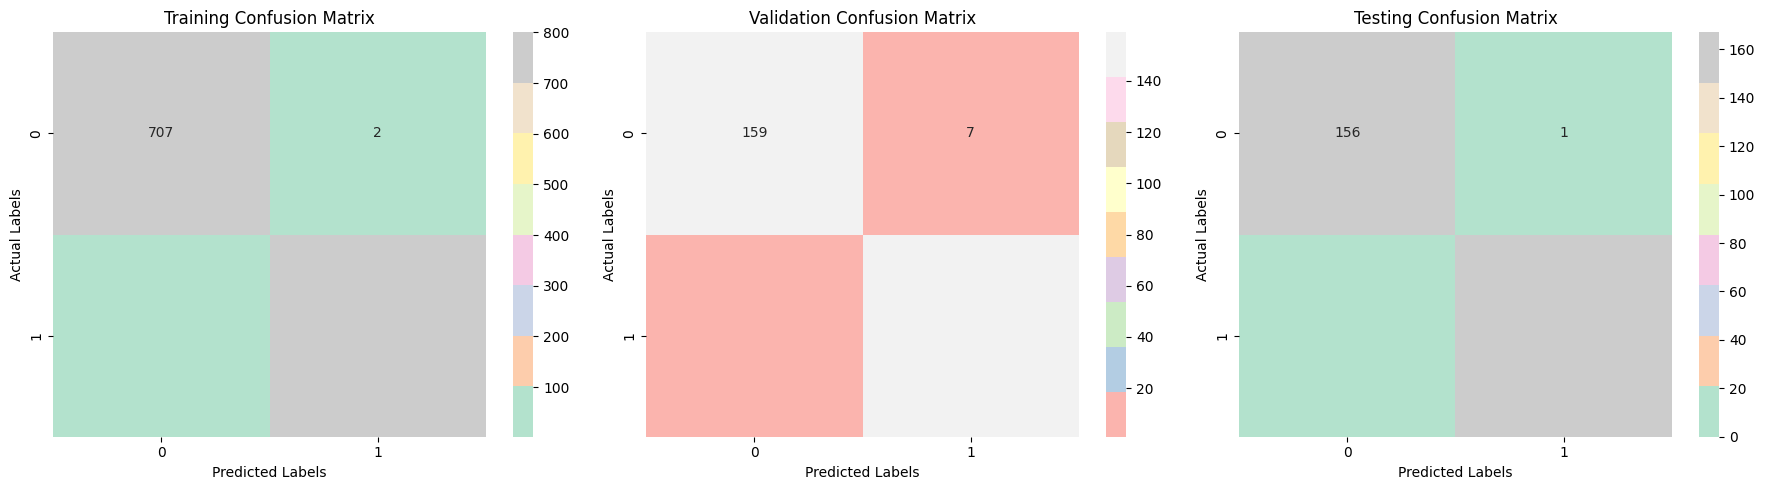

11/11 [==============================] - 7s 604ms/step
Training Set:
Accuracy: 0.9966931216931217
F1 Score: 0.9968847352024922
Loss: 0.062975212931633


Validation Set:
Accuracy: 0.9753086419753086
F1 Score: 0.9751552795031055
Loss: 0.1306936889886856


Test Set:
Accuracy: 0.9969135802469136
F1 Score: 0.9970149253731343
Loss: 0.08380559831857681




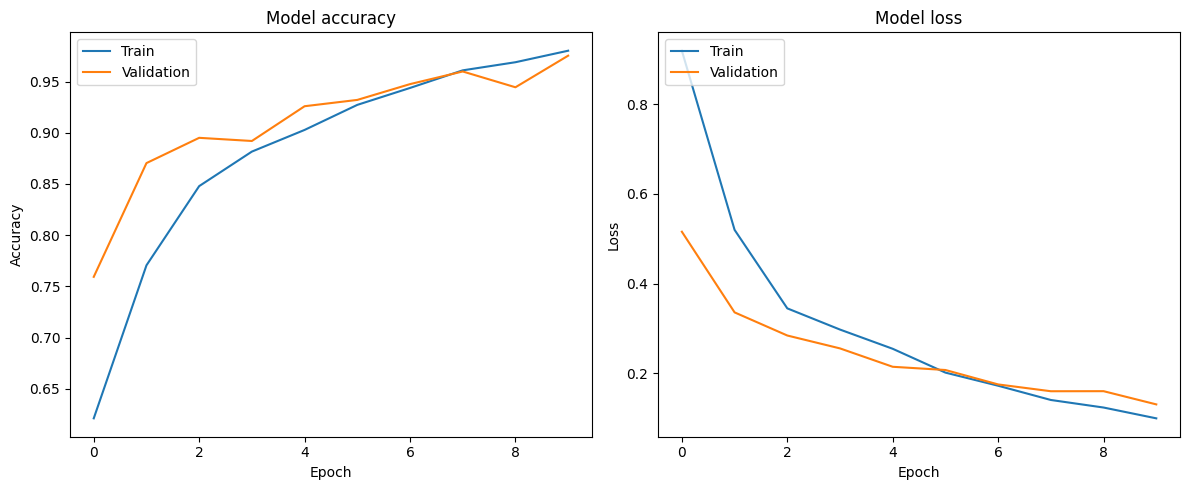

In [62]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    #print("Confusion Matrix:")
    #print(metrics['Confusion Matrix'])
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("\n")
plot_learning_curves(history)

# MobileNetV2

MobileNetV2 is a lightweight deep learning model designed for efficient deployment on resource-constrained devices like mobile phones and embedded systems. It leverages depth-wise separable convolutions to reduce computational complexity while maintaining high accuracy in image recognition tasks. This architecture allows MobileNetV2 to achieve state-of-the-art performance on various tasks, making it a popular choice for mobile applications requiring real-time image processing. Its compact size and impressive performance make it a versatile option for a wide range of computer vision applications on devices with limited computational resources.

In [63]:
def build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test):
    # Load the MobileNetV2 model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Define the final model
    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(X_train, y_train)
    y_train_pred = model.predict(X_train)
    train_cm = tf.math.confusion_matrix(y_train, y_train_pred > 0.5)

    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    y_val_pred = model.predict(X_val)
    val_cm = tf.math.confusion_matrix(y_val, y_val_pred > 0.5)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    y_test_pred = model.predict(X_test)
    test_cm = tf.math.confusion_matrix(y_test, y_test_pred > 0.5)

    return train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history

In [64]:
train_loss, train_accuracy, y_train_pred, train_cm, val_loss, val_accuracy, y_val_pred, val_cm, test_loss, test_accuracy, y_test_pred, test_cm, model, history = build_and_train_mobilenetv2(X_train, y_train, X_val, y_val, X_test, y_test)

Epoch 1/10
48/48 [==============================] - 12s 185ms/step - loss: 0.5846 - accuracy: 0.6951 - val_loss: 0.3502 - val_accuracy: 0.8827
Epoch 2/10
48/48 [==============================] - 8s 166ms/step - loss: 0.3553 - accuracy: 0.8558 - val_loss: 0.2433 - val_accuracy: 0.9352
Epoch 3/10
48/48 [==============================] - 8s 165ms/step - loss: 0.2330 - accuracy: 0.9259 - val_loss: 0.1807 - val_accuracy: 0.9784
Epoch 4/10
48/48 [==============================] - 8s 169ms/step - loss: 0.1835 - accuracy: 0.9471 - val_loss: 0.1407 - val_accuracy: 0.9815
Epoch 5/10
48/48 [==============================] - 8s 168ms/step - loss: 0.1463 - accuracy: 0.9643 - val_loss: 0.1116 - val_accuracy: 0.9846
Epoch 6/10
48/48 [==============================] - 8s 168ms/step - loss: 0.1093 - accuracy: 0.9769 - val_loss: 0.1006 - val_accuracy: 0.9877
Epoch 7/10
48/48 [==============================] - 8s 165ms/step - loss: 0.0959 - accuracy: 0.9821 - val_loss: 0.0807 - val_accuracy: 0.9815
Epoch

11/11 [==============================] - 2s 144ms/step


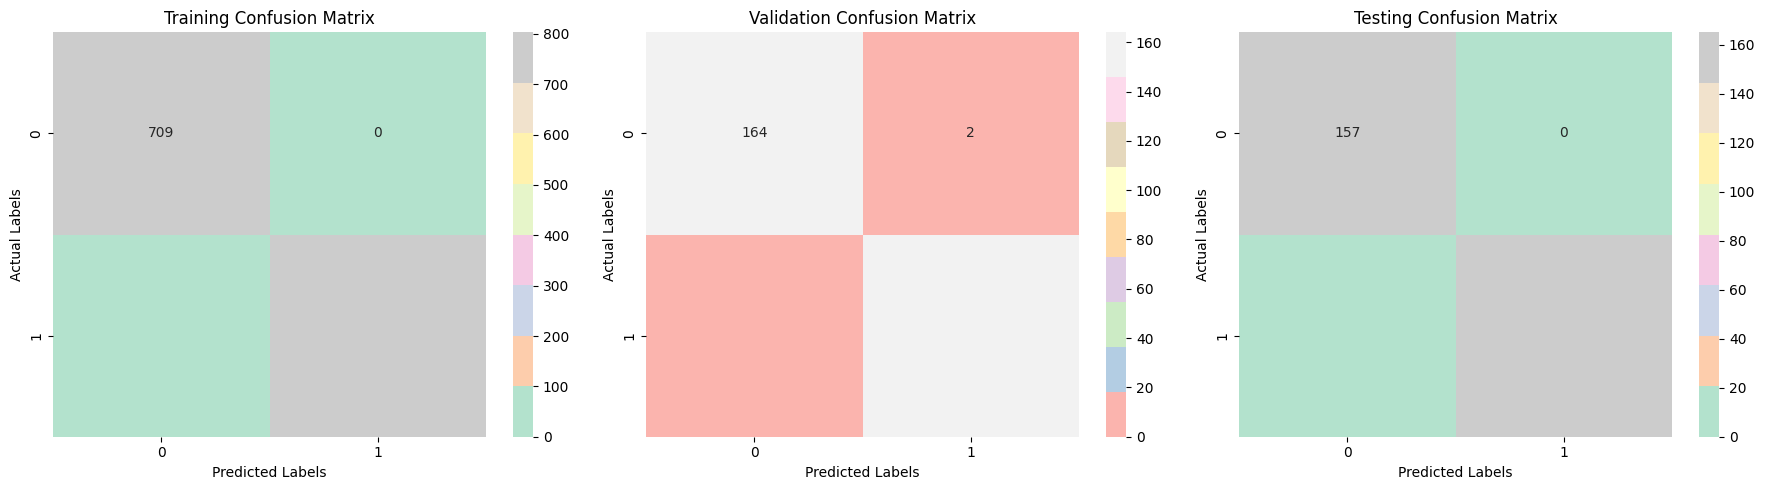

11/11 [==============================] - 1s 123ms/step
Training Set:
Accuracy: 1.0
F1 Score: 1.0
Loss: 0.03156130388379097


Validation Set:
Accuracy: 0.9938271604938271
F1 Score: 0.9937106918238994
Loss: 0.05322970822453499


Test Set:
Accuracy: 0.9938271604938271
F1 Score: 0.9939759036144578
Loss: 0.06206004321575165




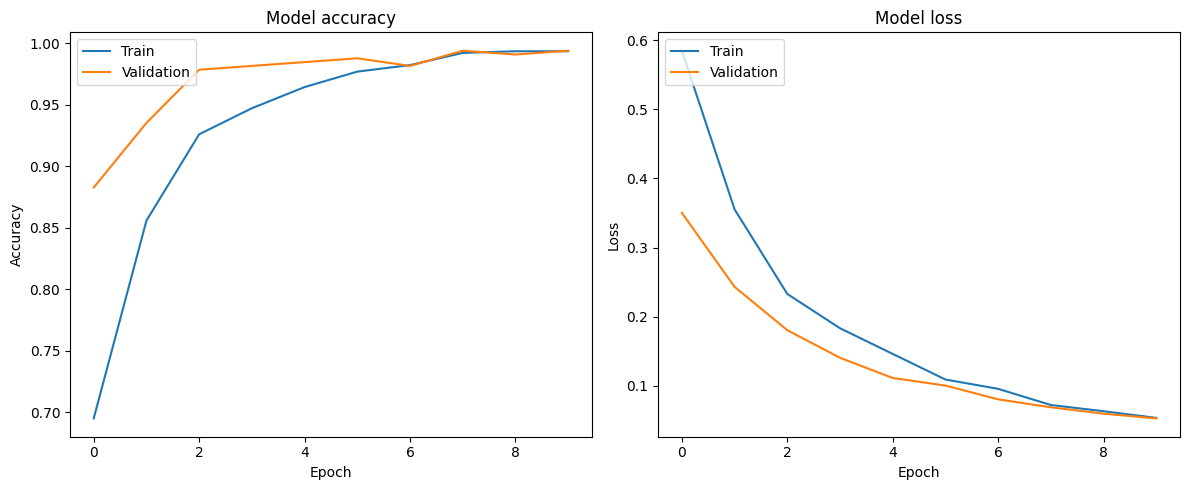

In [65]:
evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test)
results = evaluate_model_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test)
for set_name, metrics in results.items():
    print(f"{set_name} Set:")
    #print("Confusion Matrix:")
    #print(metrics['Confusion Matrix'])
    print("Accuracy:", metrics['Accuracy'])
    print("F1 Score:", metrics['F1 Score'])
    print("Loss:", metrics['Loss'])
    print("\n")
plot_learning_curves(history)

# Yolo v8

In [43]:
import os

# Define the base directory path
base_dir = "E:/OneDrive - University of Ottawa/CV/CV Project/Data"
test_dir = "E:\OneDrive - University of Ottawa\CV\CV Project\Data test"



In [ ]:
# from PIL import Image

# # Function to save images in the specified directory
# def save_images(data, split_type):
#     for index, row in data.iterrows():
#         img_array = row['img']
#         class_label = row['z']

#         class_name = 'Shoe' if class_label == 1 else 'No_Shoe'

#         if split_type == 'test':
#             image_filename = f"{class_name}_{index}.jpg"
#             image_path = os.path.join(test_dir, split_type, class_name, image_filename)
#         else:
#             image_filename = f"{class_name}_{index}.jpg"
#             image_path = os.path.join(base_dir, split_type, class_name, image_filename)

#         image_filename = f"{class_name}_{index}.jpg"
#         image_path = os.path.join(base_dir, split_type, class_name, image_filename)

#         image = Image.fromarray(img_array)
#         image.save(image_path)

# # Save images for train, validation,z and test sets
# save_images(train_data, 'train')
# save_images(val_data, 'val')
# save_images(test_data, 'test')

In [49]:
import os

from ultralytics import YOLO


# Load a model
model = YOLO("yolov8n-cls.pt")  # load a pretained model

# Use the model
results = model.train(data=base_dir, epochs=4, imgsz=128)  # train the model

New https://pypi.org/project/ultralytics/8.0.208 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.181  Python-3.11.5 torch-2.0.1+cpu CPU (Intel Core(TM) i7-10700 2.90GHz)
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=E:/OneDrive - University of Ottawa/CV/CV Project/Data, epochs=4, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=Non

In [50]:
def plot_confusion_matrix(TP, TN, FP, FN):
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Shoe", "No Shoe"], rotation=45)
    plt.yticks(tick_marks, ["Shoe", "No Shoe"])

    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="white" if i == j else "black")

    plt.tight_layout()
    plt.show()

In [ ]:
# Load a model
# model = YOLO('yolov8n-cls.pt')  # load an official model
model = YOLO(r"E:\OneDrive - University of Ottawa\CV\CV Project\PreProcess\runs\classify\train6\weights\best.pt")  # load a custom model

# Predict with the model
shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data test\test\Shoe")  # predict on an image
no_shoe = model(r"E:\OneDrive - University of Ottawa\CV\CV Project\Data test\test\No_Shoe")  # predict on an image

In [58]:
counts=[]
for result in shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts.append(index)
TP = counts.count(1)
FN = counts.count(0)

counts1=[]
for result in no_shoe:
    probs = result.probs.data.tolist()
    # print(probs)
    index = probs.index(max(probs))
    counts1.append(index)
TN = counts1.count(0)
FP = counts1.count(1)

confusion_matrix_data = [[TN, FP], [FN, TP]]

print("TP:",TP)
print("FP:",FP)
print("TN:",TN)
print("FN:",FN)

TP: 166
FP: 0
TN: 157
FN: 1


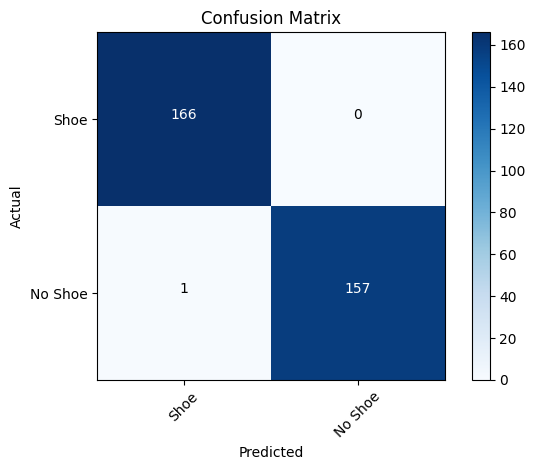

Test Accuracy: 0.9969135802469136
Test Recall: 0.9940119760479041
Test Precision: 1.0
Test F1-score: 0.996996996996997


In [59]:
plot_confusion_matrix(TP, TN, FP, FN)

# Calculate Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Calculate Precision
precision = TP / (TP + FP)

# Calculate Recall
recall = TP / (TP + FN)

# Calculate F1-Score
f1 = (2 * precision * recall) / (precision + recall)

print("Test Accuracy:", accuracy)
print("Test Recall:", recall)
print("Test Precision:", precision)
print("Test F1-score:", f1)